In [1]:
import os
import pandas as pd
import numpy as np
import concurrent.futures
from phylib.io.model import load_model
from umap import UMAP
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

# Constants
BASE_DIR = r'.\test2'
RAND_STATE = 42

def process_folder(folder):
    cluster_info_path = os.path.join(folder, 'phy', 'cluster_info.tsv')
    params_path = os.path.join(folder, 'phy', 'params.py')
    
    # Read the TSV file
    try:
        cluster_info = pd.read_csv(cluster_info_path, sep='\t')
    except FileNotFoundError:
        return None
    
    good_clusters = np.intersect1d(
        cluster_info['cluster_id'][cluster_info['group'] == 'good'],
        cluster_info['cluster_id'][cluster_info['fr'] > 0.5]
    )
    
    # Load the TemplateModel
    model = load_model(params_path)
    
    def process_cluster(cluster_id):
        waveforms = model.get_cluster_spike_waveforms(cluster_id)[:, :, 0]
        return waveforms

    # Use ThreadPoolExecutor to handle clusters in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        waveforms = list(executor.map(process_cluster, good_clusters))
    
    return waveforms

def main():
    # Retrieve all recording folders
    folders = [os.path.join(BASE_DIR, f) for f in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, f))]
    
    # Process each folder concurrently
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(executor.map(process_folder, folders))
    
    # Combine all waveforms into a single array
    all_waveforms = [wf for result in results if result for wf in result]
    
    if not all_waveforms:
        print("No waveforms found.")
        return

    # Normalize waveforms
    normWFs_array = np.array([normalize(wf.mean(axis=0).reshape(1, -1), norm='max').squeeze() for wf in all_waveforms])
    
    # Perform UMAP
    reducer = UMAP(random_state=RAND_STATE, n_neighbors=15)
    embedding = reducer.fit_transform(normWFs_array)

    # Plotting
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
    plt.title('UMAP Projection of Waveforms')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()

if __name__ == "__main__":
    main()

C:\Users\short\miniforge3\envs\WaveMAP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

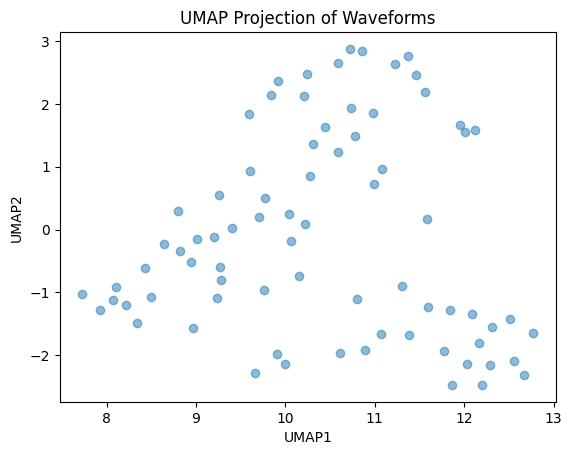

In [2]:
import os
import pandas as pd
import numpy as np
import concurrent.futures
from phylib.io.model import load_model
from umap import UMAP
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

# Constants
BASE_DIR = r'.\test2'
RAND_STATE = 42

def process_folder(folder):
    cluster_info_path = os.path.join(folder, 'phy', 'cluster_info.tsv')
    params_path = os.path.join(folder, 'phy', 'params.py')
    
    # Read the TSV file
    try:
        cluster_info = pd.read_csv(cluster_info_path, sep='\t')
    except Exception as e:
        print(f"Error reading {cluster_info_path}: {e}")
        return None
    
    try:
        good_clusters = np.intersect1d(
            cluster_info['cluster_id'][cluster_info['group'] == 'good'],
            cluster_info['cluster_id'][cluster_info['fr'] > 0.5]
        )
        
        # Load the TemplateModel
        model = load_model(params_path)
        
        waveforms = [model.get_cluster_spike_waveforms(cluster_id)[:, :, 0] for cluster_id in good_clusters]
        return waveforms
    except Exception as e:
        print(f"Error processing data in {folder}: {e}")
        return None

def main():
    # Retrieve all recording folders
    folders = [os.path.join(BASE_DIR, f) for f in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, f))]
    
    # Process each folder
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        for result in executor.map(process_folder, folders):
            if result:
                results.extend(result)

    # Combine all waveforms into a single array
    all_waveforms = [wf for wf in results if wf is not None]
    
    if not all_waveforms:
        print("No waveforms found.")
        return

    # Normalize waveforms
    normWFs_array = np.array([normalize(wf.mean(axis=0).reshape(1, -1), norm='max').squeeze() for wf in all_waveforms])
    
    # Perform UMAP
    reducer = UMAP(random_state=RAND_STATE, n_neighbors=15)
    embedding = reducer.fit_transform(normWFs_array)

    # Plotting
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
    plt.title('UMAP Projection of Waveforms')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()

if __name__ == "__main__":
    main()
